In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RANDOM_STATE = 42
TEST_SIZE = 0.25

COLORS = ['#408FB0', '#50B985', '#DB565F', '#FCB06E']
customPalette = sns.set_palette(sns.color_palette(COLORS))


# загружаем датасет
df = pd.read_csv('insurance.csv')
df[:4]

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061


## Признаки:

- age - возраст
- sex - пол
- bmi - индекс массы тела
- children - количество детей
- smoker - курит или нет
- region - регион проживания
- charges - индивидуальные медицинские расходы, оплачиваемые медицинской страховкой

Заменим значение 'yes' на 1, а 'no' на 0.  

In [2]:
df.smoker = df.smoker.map({"yes":1, "no": 0})
df[:4]

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 73.3+ KB


In [4]:
df.describe()

,age,bmi,children,smoker,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.204783,13270.422265
std,14.049960,6.098187,1.205493,0.403694,12110.011237
min,18.000000,15.960000,0.000000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,0.000000,9382.033000
75%,51.000000,34.693750,2.000000,0.000000,16639.912515
max,64.000000,53.130000,5.000000,1.000000,63770.428010


In [5]:
df.describe(include='object')

,sex,region
count,1338,1338
unique,2,4
top,male,southeast
freq,676,364


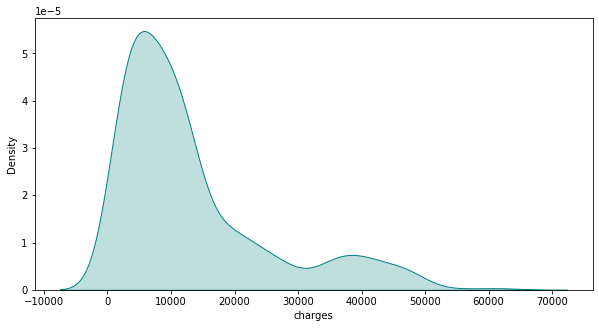

In [6]:
plt.figure(figsize=(10, 5))

sns.kdeplot(df.charges, fill=True, color='teal');

Отметим, что распределение ненормальное, есть длинных хвост, поэтому стоит аккуратно подходить к выбору метрики. Больше всего будем ориентироваться на MAE, так как метрику устойчива к выбросам.

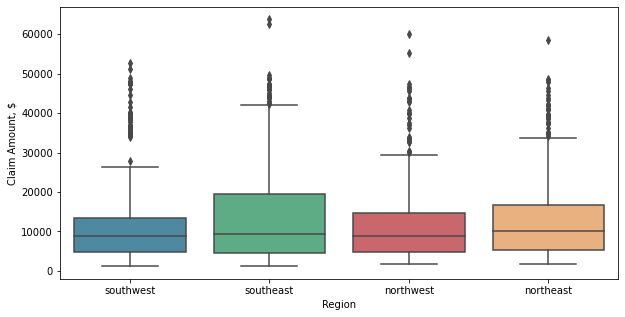

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='region', y='charges', palette=customPalette)
plt.xlabel('Region')
plt.ylabel('Claim Amount, $')
plt.show()

Для каждого региона графики показывают, что расходы, оплачиваемые медицинской страховкой, имеют немного разные значения. Charges имеет больший разброс в Юго-Восточном регионе, а также самые высокие максимальные значения. В Северо-Восточном регионе самая высокая медианная стоимость, но большой разницы между другими регионами нет.

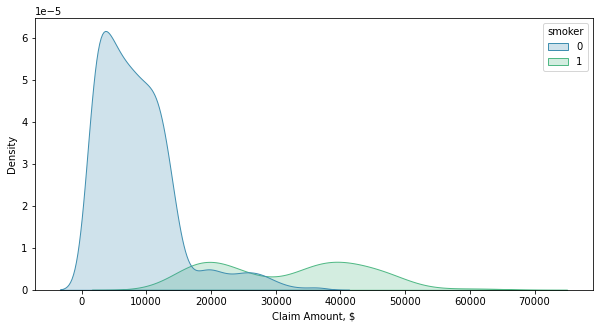

In [8]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, hue='smoker', x='charges', fill=True)
plt.xlabel('Claim Amount, $')
plt.show()

In [9]:
df.groupby('smoker')['charges'].median()

smoker
0     7345.40530
1    34456.34845
Name: charges, dtype: float64

Медианное значение суммы charges для курильщиков составляет около 34456 долларов, что почти в 5 раз выше суммы для некурящих. Распределение расходов на страхование между группами также заметно отличается: для некурящих распределение смещено влево, для курильщиков распределение расходов имеет больший разброс значений, а также смещено правее.

Добавим бины для анализа признака age в разрезе целевой переменной charges

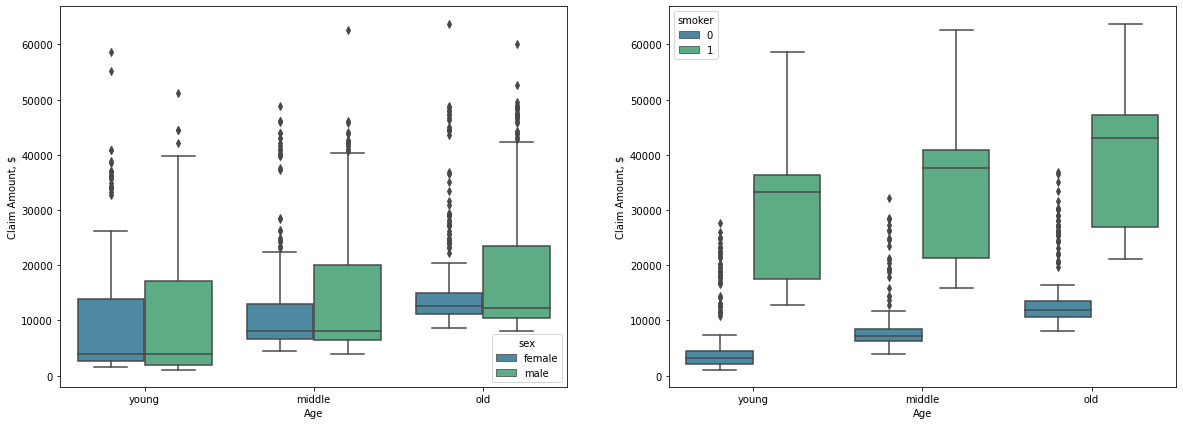

In [10]:
df_ = df.copy()
df_['age_bins'] = pd.cut(df_.age, bins=3, labels=["young", "middle", "old"])


fig, axes = plt.subplots(ncols=2, figsize=(20, 7))
sns.boxplot(data=df_,
            x='age_bins',
            y='charges',
            hue='sex',
            palette=customPalette,
            ax=axes[0])

sns.boxplot(data=df_,
            x='age_bins',
            y='charges',
            hue='smoker',
            palette=customPalette,
            ax=axes[1])

axes[0].set_xlabel('Age')
axes[0].set_ylabel('Claim Amount, $')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Claim Amount, $')

plt.show()

Чем выше значение возраста, тем больше расходов на страховку. Для мужчин разброс значений расходов на страховку больше, 
чем у женщин. Также вне зависимости от возраста, у курящих и разброс значений и максимальные значения charges больше, 
чем у некурящий, но также в возрастом эти траты увеличиваются как для курящих, так и для некурящих.

In [10]:
X = pd.get_dummies(df.drop('charges', axis=1))
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= TEST_SIZE,
                                                    random_state= RANDOM_STATE)

Так как мы хотим использовать метрический алгоритм, то необходимо нормировать данные. Вторым шагом необходимо обучить baseline (модель со значениями параметров по умолчанию). Чтобы сократить количество строк кода и сделать наше обучение и предобработку данных более удобными, давайте воспользуемся таким инструментом как Pipeline

In [11]:
# Используем конвейер, чтобы объединить несколько действий
pipe = Pipeline(steps=[("minmax", MinMaxScaler()), ("knn", KNeighborsRegressor())])
# обучим модель - бейзлан
pipe.fit(X_train, y_train)

Pipeline(steps=[('minmax', MinMaxScaler()), ('knn', KNeighborsRegressor())])

In [12]:
def r2_adjusted(y_test, y_pred, X_test):
    """Коэффициент детерминации для множественной регрессии"""

    n = len(y_test)
    h = X_test.shape[1]
    r2 = r2_score(y_test, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - h - 1)


def get_metrics(y_test, model, X_test, name):
    """Получение датасета с метриками"""

    y_pred = model.predict(X_test)

    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['MAE'] = [mean_absolute_error(y_test, y_pred)]
    df_metrics['MSE'] = [mean_squared_error(y_test, y_pred)]
    df_metrics['RMSE'] = [np.sqrt(mean_squared_error(y_test, y_pred))]
    df_metrics['R2 adjusted'] = [r2_adjusted(y_test, y_pred, X_test)]
    return df_metrics

In [13]:
metrics = get_metrics(y_train, pipe, X_train, 'KNN train')
metrics = metrics.append(get_metrics(y_test, pipe, X_test, 'KNN test'))
round(metrics.set_index('model'), 2)

,MAE,MSE,RMSE,R2 adjusted
model,,,,
KNN train,2850.47,23090685.77,4805.28,0.84
KNN test,3570.26,33099086.69,5753.18,0.77


Видим разницу между метриками на train и test, но пока все же модель не близка к переобучению. Бейзлайн отработал хорошо, 
если ориентироваться на r 2adjusted, но все еще модель далека от идеальной.

Теперь попробуем подобрать лучшие параметры для алгоритма KNN с использованием Pipeline и GridSearchCV

In [14]:
# создадим словарь с параметрами, которые хотим установить и перебрать
parameters = {
    'knn__n_neighbors': list(range(3, 32, 2)),
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__algorithm': ["auto", "ball_tree", "kd_tree", "brute"]
}

# подаем на вход модель, словарь с параметрами, установим, на какую метрику ориентироваться
clf = GridSearchCV(estimator=pipe,
                   param_grid=parameters,
                   scoring='neg_mean_absolute_error',
                   cv=3,
                   verbose=0)
clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21, 23, 25, 27, 29, 31]},
             scoring='neg_mean_absolute_error')

In [16]:
# Посмотрим на лучшие значения параметров
clf.best_estimator_

Pipeline(steps=[('minmax', MinMaxScaler()),
                ('knn',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=3))])

Получается, что модель лучше всего работает, когда KNN использует 3 соседей и манхэттенское расстояние при поиске ближайших соседей.

Оценим, как изменились метрики

In [17]:
# получение предсказаний
metrics = metrics.append(
    get_metrics(y_train, clf, X_train, 'KNN Grid train'))
metrics = metrics.append(get_metrics(y_test, clf, X_test, 'KNN Grid test'))
round(metrics.set_index('model'), 2)

,MAE,MSE,RMSE,R2 adjusted
model,,,,
KNN train,2850.47,23090685.77,4805.28,0.84
KNN test,3570.26,33099086.69,5753.18,0.77
KNN Grid train,2375.90,18347891.76,4283.44,0.87
KNN Grid test,3361.65,32200058.56,5674.51,0.78


Стоит также рассмотреть и линейные модели, так как есть корреляция между признаками и целевой переменной. 

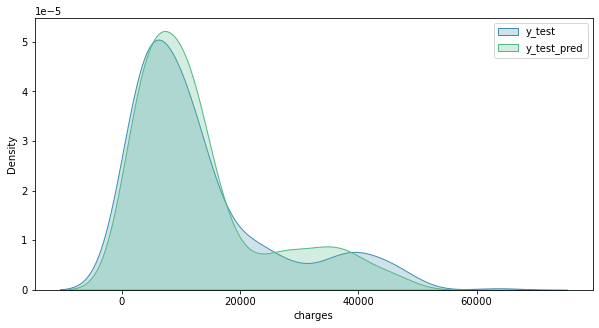

In [18]:
# Посмотрим на распределения предсказанных значений и тестовых данных.
y_pred_test = clf.predict(X_test)

plt.figure(figsize=(10, 5))
sns.kdeplot(y_test, fill=True, palette=customPalette, label='y_test');
sns.kdeplot(y_pred_test, fill=True, palette=customPalette, label='y_test_pred')
plt.legend()
plt.show()

Можно отметить, что алгоритм с лучшими параметрами довольно хорошо описал свойства распределения, а также разброс значений

Дополнительно найдем важные признаки, которые влияют на результат модели с помощью permutation_importance()

In [20]:
from sklearn.inspection import permutation_importance


results = permutation_importance(clf,
                                 X_test,
                                 y_test,
                                 n_repeats=30,
                                 random_state=RANDOM_STATE,
                                 scoring='neg_mean_squared_error')

perm_df = pd.DataFrame({'col': X.columns, 'value': results.importances_mean})
perm_df = round(perm_df.sort_values(by='value', ascending=False), 1)
perm_df[:4]

,col,value
3,smoker,204581705.7
0,age,29512183.0
1,bmi,23203403.1
2,children,5712797.6


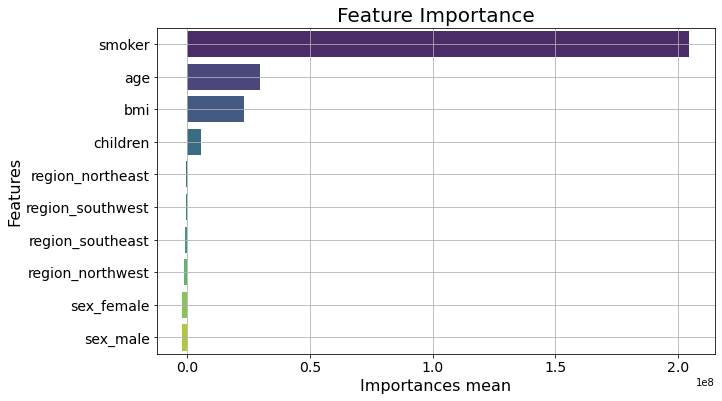

In [21]:
plt.figure(figsize=(10, 6))

b = sns.barplot(data=perm_df, y="col", x="value", palette='viridis')

b.set_xlabel('Importances mean', fontsize=16);
b.set_ylabel('Features', fontsize=16);
b.set_title('Feature Importance', fontsize=20)
b.tick_params(labelsize=14)

plt.grid()
plt.show()